In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler,QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
MDATA_PATH = '/home/chingisbadmaev/Desktop/sirius_university/machine_learning/task_4_preprocessing/mdata'

In [3]:
def get_dates():
    return sorted(os.listdir(MDATA_PATH))

def get_tickers(date):
    return sorted(os.listdir(os.path.join(MDATA_PATH,date)))

In [4]:
dates = get_dates()

date_tickers = dict([(date,get_tickers(date)) for date in dates])
tickers = np.unique(np.concatenate(list(date_tickers.values()))).tolist()

In [5]:
def get_market_data(ticker):
    data = []
    for date in tqdm(dates):
        #print (date)
        if not os.path.exists(os.path.join(MDATA_PATH,date,ticker)):
            continue
        df = pd.read_csv(
            os.path.join(MDATA_PATH,date,ticker),
            compression='gzip',
            dtype={'bar_time':float,'TIMESTAMP':float},
            index_col=0,
            parse_dates=[2,3],
            date_parser=pd.to_datetime,
        )
        df.drop([
                'TIMESTAMP','WEEKDAY','MINUTE','HOUR','ZERO_SPREAD_ON_TRADE','EMPTY_LOB_SIDE_AFTER_UPDATE','NEGATIVE_SPREAD_AFTER_UPDATE',
                'ZERO_SPREAD_AFTER_UPDATE','EMPTY_LOB_SIDE_ON_TRADE','NEGATIVE_SPREAD_ON_TRADE','bar_count','BAR_DURATION'
            ], axis = 1, inplace = True
        )
        df = df[df.columns[~df.columns.str.startswith('EXEC')]]
        data.append(df)
    data = pd.concat(data).set_index('bar_time').sort_index()
    
    price_grid = data.filter(like='PRICE_GRID')
    vol_grid = data.filter(like='VOL_GRID')
    
    data = data[ data.columns[ ~data.columns.str.startswith('PRICE_GRID') & ~data.columns.str.startswith('VOL_GRID') ] ]
    
    return data,price_grid,vol_grid

In [6]:
ticker = 'Z.BNB'

In [7]:
mdata,pgrid,vgrid = get_market_data(ticker)

100%|██████████| 292/292 [00:27<00:00, 10.43it/s]


In [8]:
returns_ahead = mdata['LAST'].pct_change().shift(-1).fillna(0)

In [9]:
# EXCLUDING NON-STATIONARY DATA HARD-CODED.
mdata.drop(['BEST_BID','BEST_ASK','LAST','HIGH','LOW','VWAP'],axis=1,inplace=True)

In [10]:
mdata

,BEST_BID_VOL,BEST_ASK_VOL,VOLUME,DVOL,ENTROPY,COUNT,COUNT_BUY,COUNT_SELL,MO_COUNT,MO_COUNT_BUY,MO_COUNT_SELL,MO_AVG,MO_AVG_BUY,MO_AVG_SELL,BREAK_BEST_DOWN,BREAK_BEST_UP,ASK_VOLUME,BID_VOLUME
bar_time,,,,,,,,,,,,,,,,,,
2021-01-01 00:02:01.217999872,4.77,8.50,4391.02,-1552.70,4.127526,438.0,207.0,231.0,213.0,120.0,93.0,20.615117,11.826333,31.955484,231.0,213.0,18755.92,27527.40
2021-01-01 00:05:06.065999872,1.21,1.00,2130.10,-816.20,3.993499,270.0,121.0,149.0,140.0,68.0,73.0,15.215000,9.661029,20.180137,266.0,271.0,23372.11,19986.57
2021-01-01 00:08:29.527000064,5.20,17.48,10550.33,-4129.01,4.539145,879.0,330.0,549.0,383.0,168.0,215.0,27.546554,19.111071,34.138000,427.0,482.0,24190.63,30379.25
2021-01-01 00:10:31.216999936,15.21,19.79,1207.84,333.80,3.511316,227.0,125.0,102.0,143.0,75.0,68.0,8.446434,10.277600,6.426765,289.0,283.0,25486.49,24804.37
2021-01-01 00:12:11.052999936,30.54,0.02,1789.89,625.29,3.326114,201.0,131.0,70.0,119.0,80.0,39.0,15.041092,15.094875,14.930769,213.0,170.0,30774.22,32077.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31 23:37:08.680000000,21.17,15.82,1181.42,260.82,4.541543,1670.0,1213.0,457.0,641.0,442.0,199.0,1.843089,1.631493,2.313065,94.0,142.0,52921.53,103583.77
2021-10-31 23:42:08.324000000,12.75,12.70,2427.10,249.50,4.386298,1917.0,1188.0,729.0,602.0,280.0,323.0,4.031728,4.779643,3.370898,121.0,95.0,52234.27,102457.48
2021-10-31 23:47:08.182000128,1.14,1.16,2034.80,309.38,4.041020,1735.0,1052.0,683.0,501.0,233.0,268.0,4.061477,5.030429,3.219067,97.0,86.0,52185.60,102157.45


In [11]:
returns_ahead

bar_time
2021-01-01 00:02:01.217999872   -0.003446
2021-01-01 00:05:06.065999872   -0.003350
2021-01-01 00:08:29.527000064    0.000027
2021-01-01 00:10:31.216999936   -0.001237
2021-01-01 00:12:11.052999936   -0.001642
                                   ...   
2021-10-31 23:37:08.680000000   -0.000324
2021-10-31 23:42:08.324000000    0.000057
2021-10-31 23:47:08.182000128   -0.001999
2021-10-31 23:52:08.168999936    0.000839
2021-10-31 23:56:50.848000000    0.000000
Name: LAST, Length: 464078, dtype: float64

In [12]:
mdata_train, mdata_test, returns_ahead_train, returns_ahead_test = train_test_split(mdata, returns_ahead, train_size=0.8, test_size=0.2, random_state=23)

In [13]:
robust_scaler = RobustScaler().fit(mdata_train)
minmax_scaler = MinMaxScaler().fit(mdata_train)
standard_scaler = StandardScaler().fit(mdata_train)
quantile_transformer = QuantileTransformer().fit(mdata_train)

In [14]:
mdata_train_robust = robust_scaler.transform(mdata_train)
mdata_train_minmax = minmax_scaler.transform(mdata_train)
mdata_train_standard = standard_scaler.transform(mdata_train)
mdata_train_quantile = quantile_transformer.transform(mdata_train)

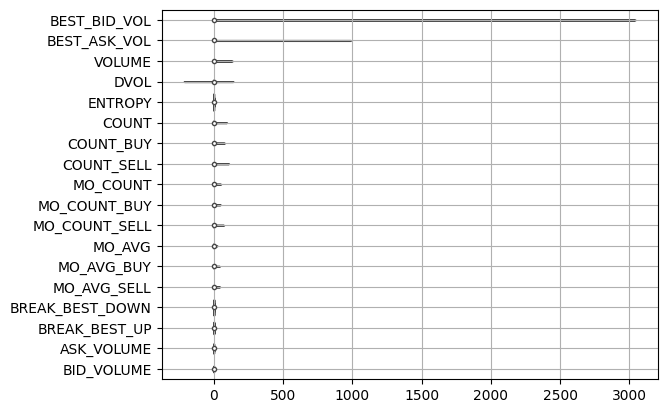

In [15]:
sns.violinplot(pd.DataFrame(mdata_train_robust,columns=mdata_train.columns),orient='h')
plt.grid()

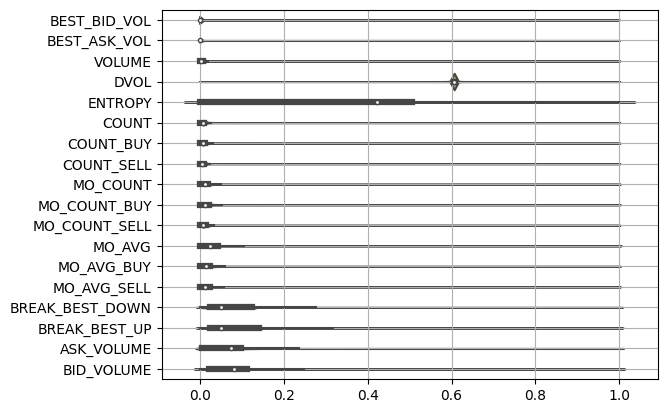

In [16]:
sns.violinplot(pd.DataFrame(mdata_train_minmax,columns=mdata_train.columns),orient='h')
plt.grid()

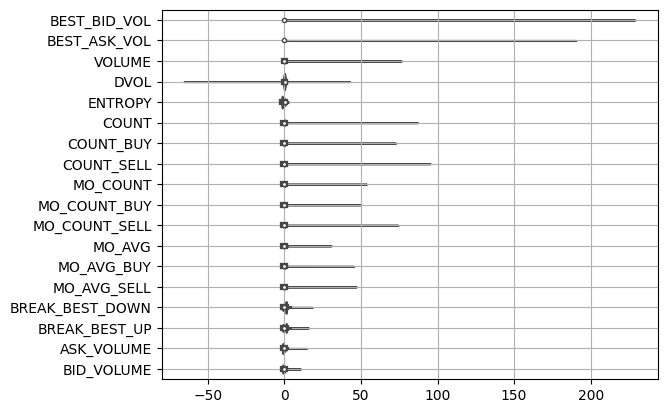

In [17]:
sns.violinplot(pd.DataFrame(mdata_train_standard,columns=mdata_train.columns),orient='h')
plt.grid()

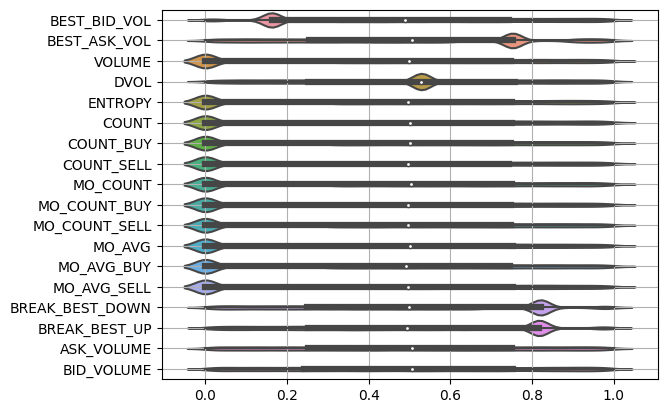

In [18]:
sns.violinplot(pd.DataFrame(mdata_train_quantile,columns=mdata_train.columns),orient='h')
plt.grid()

permutation_importance

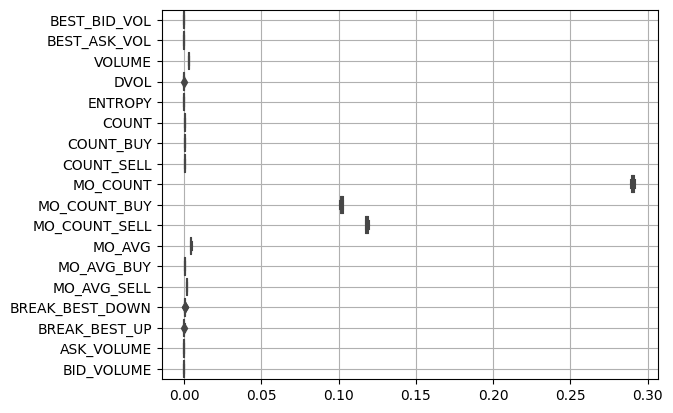

In [19]:
lr_robust = LinearRegression().fit(mdata_train_robust, returns_ahead_train.values)
result_robust = permutation_importance(lr_robust, mdata_train_robust, returns_ahead_train.values, n_repeats=10, random_state=23)
sns.boxplot(pd.DataFrame(result_robust['importances'].T,columns=mdata_train.columns),orient='h')
plt.grid()

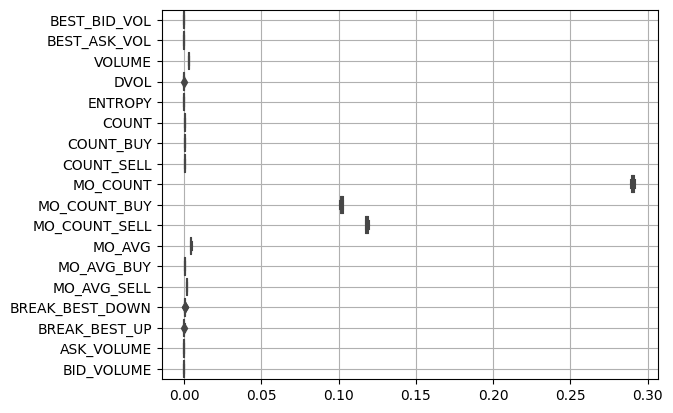

In [20]:
lr_minmax = LinearRegression().fit(mdata_train_minmax, returns_ahead_train.values)
result_minmax = permutation_importance(lr_minmax, mdata_train_minmax, returns_ahead_train.values, n_repeats=10, random_state=23)
sns.boxplot(pd.DataFrame(result_minmax['importances'].T,columns=mdata_train.columns),orient='h')
plt.grid()

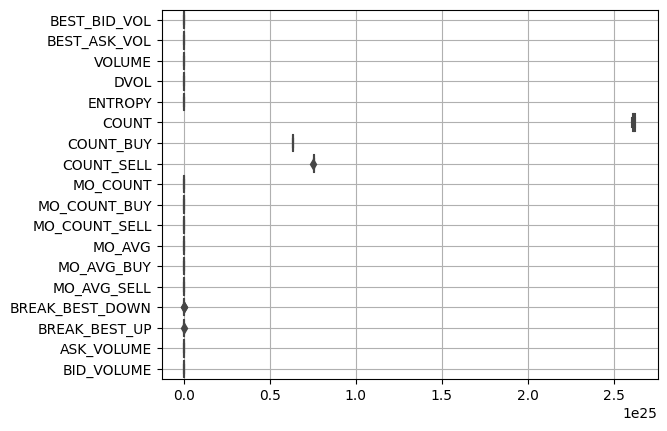

In [21]:
lr_standard = LinearRegression().fit(mdata_train_standard, returns_ahead_train.values)
result_standard = permutation_importance(lr_standard, mdata_train_standard, returns_ahead_train.values, n_repeats=10, random_state=23)
sns.boxplot(pd.DataFrame(result_standard['importances'].T,columns=mdata_train.columns),orient='h')
plt.grid()

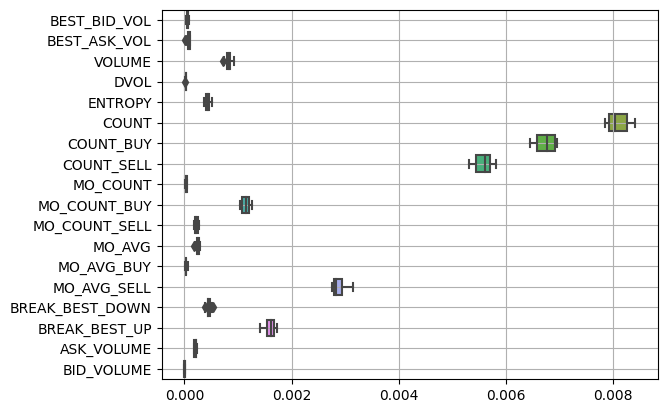

In [22]:
lr_quantile = LinearRegression().fit(mdata_train_quantile, returns_ahead_train.values)
result_quantile = permutation_importance(lr_quantile, mdata_train_quantile, returns_ahead_train.values, n_repeats=10, random_state=23)
sns.boxplot(pd.DataFrame(result_quantile['importances'].T,columns=mdata_train.columns),orient='h')
plt.grid()

fit linear regressison

In [23]:
mdata_test_robust = robust_scaler.transform(mdata_test)
mdata_test_minmax = minmax_scaler.transform(mdata_test)
mdata_test_standard = standard_scaler.transform(mdata_test)
mdata_test_quantile = quantile_transformer.transform(mdata_test)

In [24]:
y_pred_model_robust = lr_robust.predict(mdata_test_robust)
y_pred_model_minmax = lr_minmax.predict(mdata_test_minmax)
y_pred_model_standard = lr_standard.predict(mdata_test_standard)
y_pred_model_quantile = lr_quantile.predict(mdata_test_quantile)

robust, r_2 score: -0.00021318980394546827


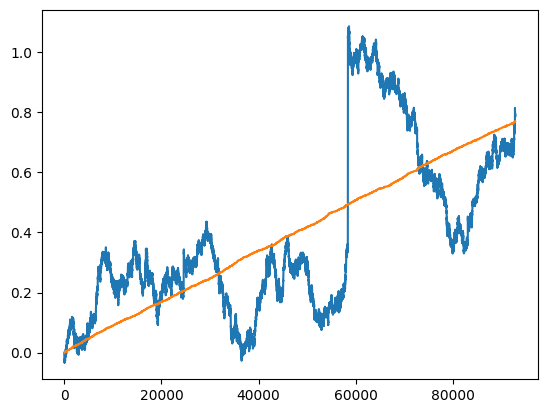

In [25]:
print('robust, r_2 score:', r2_score(returns_ahead_test, y_pred_model_robust))
plt.plot(returns_ahead_test.values.cumsum())
plt.plot(y_pred_model_robust.cumsum())

minmax, r_2 score: -0.00021318980394524623


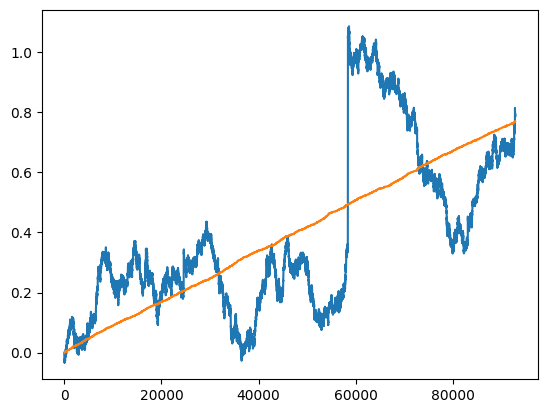

In [26]:
print('minmax, r_2 score:', r2_score(returns_ahead_test, y_pred_model_minmax))
plt.plot(returns_ahead_test.values.cumsum())
plt.plot(y_pred_model_minmax.cumsum())

standart, r_2 score: -0.0003462258418165387


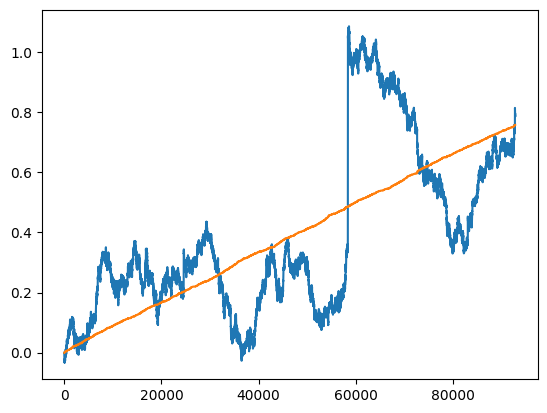

In [27]:
print('standart, r_2 score:', r2_score(returns_ahead_test, y_pred_model_standard))
plt.plot(returns_ahead_test.values.cumsum())
plt.plot(y_pred_model_standard.cumsum())

quantile, r_2 score: -8.56885367157556e-05


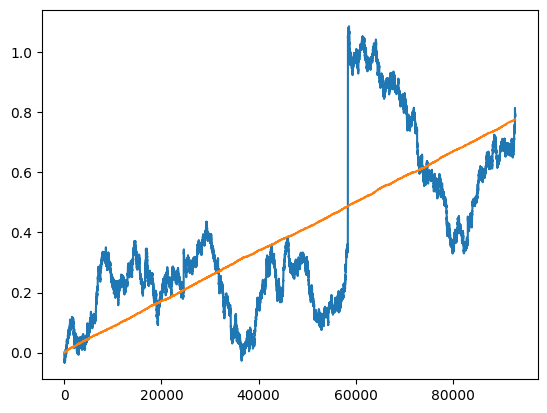

In [28]:
regr1 = r2_score(returns_ahead_test, y_pred_model_quantile)
print('quantile, r_2 score:', regr1)
plt.plot(returns_ahead_test.values.cumsum())
plt.plot(y_pred_model_quantile.cumsum())

5 strongest features:   
VOLUME  
COUNT   
COUNT_BUY   
COUNT_SELL  
MO_COUNT    
MO_COUNT_BUY    
MO_COUNT_SELL


In [29]:
mdata_best = mdata[['VOLUME', 'COUNT', 'COUNT_BUY', 'COUNT_SELL', 'MO_COUNT', 'MO_COUNT_BUY', 'MO_COUNT_SELL']]
mdata_best_train, mdata_best_test, returns_ahead_best_train, returns_ahead_best_test = train_test_split(mdata_best, returns_ahead, train_size=0.8, test_size=0.2, random_state=23)

quantile_transformer_best = QuantileTransformer().fit(mdata_best_train)
mdata_best_train_quantile = quantile_transformer_best.transform(mdata_best_train)

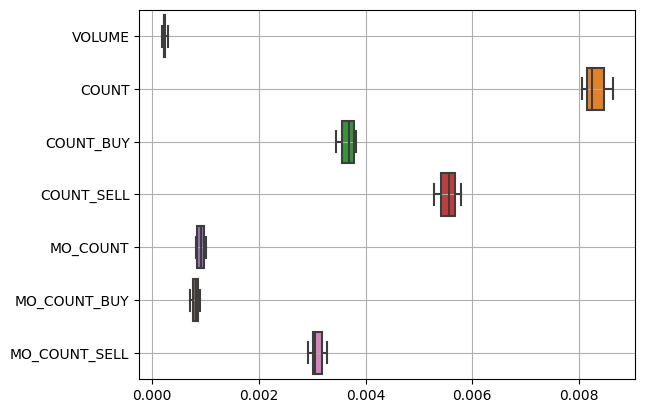

In [30]:
lr_best = LinearRegression().fit(mdata_best_train_quantile, returns_ahead_best_train.values)
result_quantile = permutation_importance(lr_best, mdata_best_train_quantile, returns_ahead_best_train.values, n_repeats=10, random_state=23)
sns.boxplot(pd.DataFrame(result_quantile['importances'].T,columns=mdata_best_train.columns),orient='h')
plt.grid()

In [31]:
mdata_best_test_quantile = quantile_transformer_best.transform(mdata_best_test)
y_pred_best_model_quantile = lr_best.predict(mdata_best_test_quantile)

quantile, r_2 score: 6.149141016353887e-05


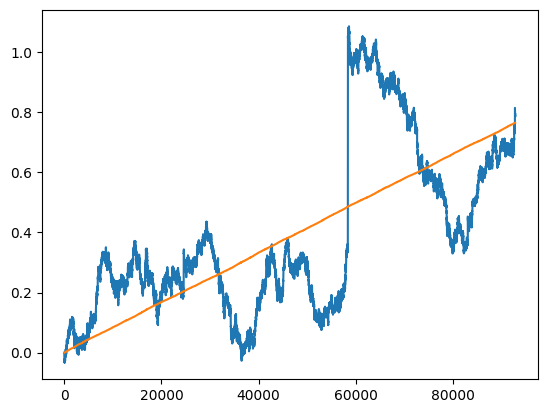

In [32]:
regr2 = r2_score(returns_ahead_best_test, y_pred_best_model_quantile)
print('quantile, r_2 score:', regr2)
plt.plot(returns_ahead_best_test.values.cumsum())
plt.plot(y_pred_best_model_quantile.cumsum())

compare results

In [33]:
print('all features:', regr1)
print('best features:', regr2)

all features: -8.56885367157556e-05
best features: 6.149141016353887e-05


delete outliers

In [34]:
temp = pd.DataFrame(returns_ahead_best_test)
temp[temp['LAST'] == temp['LAST'].max()]

,LAST
bar_time,
2021-02-22 10:11:28.072999936,0.691565


In [35]:
temp[temp['LAST'] == temp['LAST'].max()] = temp[temp['LAST'] > 0].mean()
temp[temp['LAST'] == temp['LAST'].max()]

,LAST
bar_time,
2021-06-17 09:54:02.343000064,0.124757


In [36]:
mdata_best_test_quantile = quantile_transformer_best.transform(mdata_best_test)
y_pred_best_model_quantile = lr_best.predict(mdata_best_test_quantile)

quantile, r_2 score: -8.878082506447171e-05


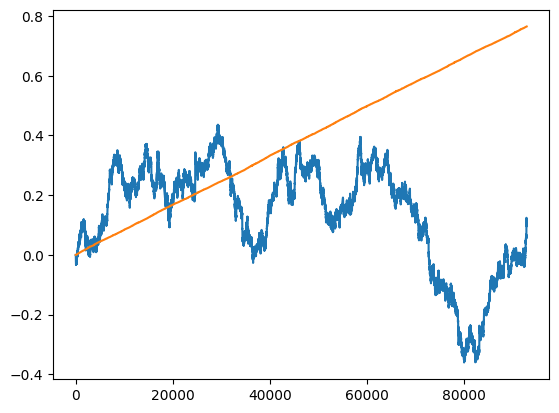

In [37]:
regr2 = r2_score(temp, y_pred_best_model_quantile)
print('quantile, r_2 score:', regr2)
plt.plot(temp.values.cumsum())
plt.plot(y_pred_best_model_quantile.cumsum())